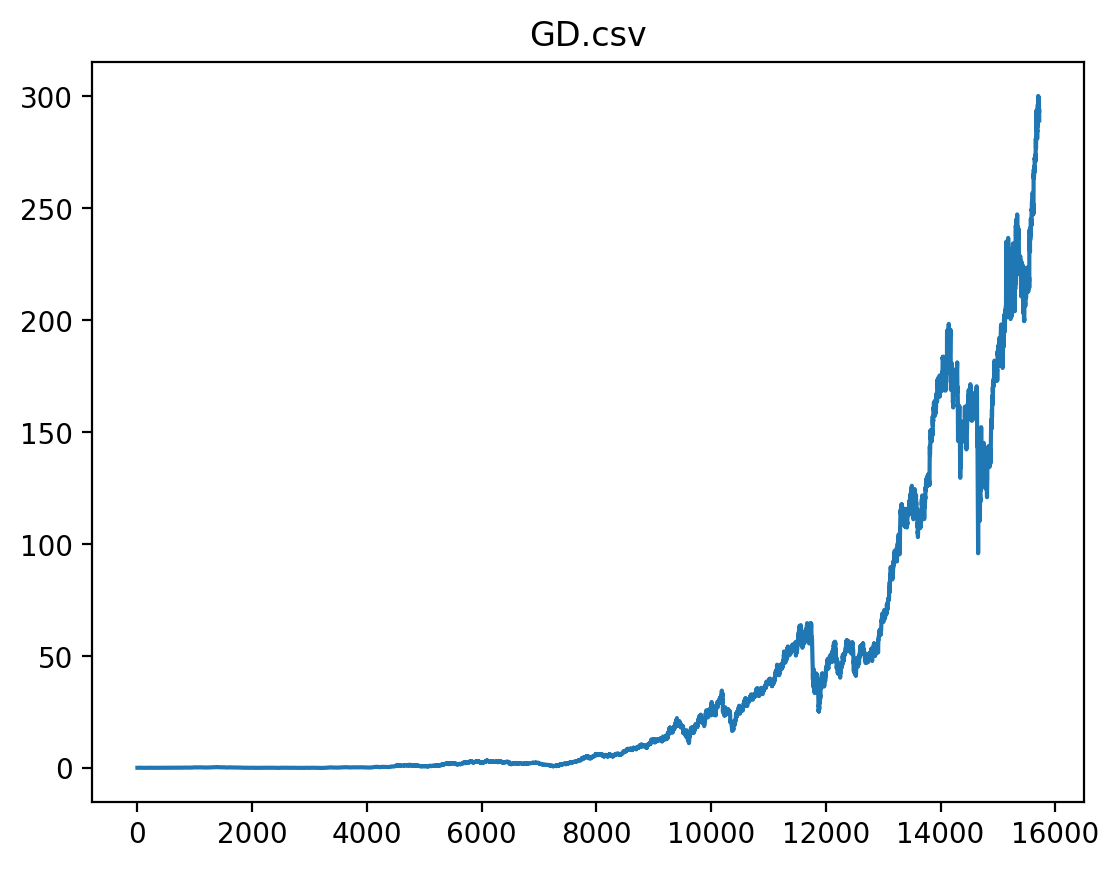

In [170]:
from matplotlib import pyplot as plt
from dataclasses import dataclass
from torch import optim
from torch import nn
import pandas as pd

%config InlineBackend.figure_format='retina'

y = pd.read_csv("GD.csv")
y = y.iloc[:, -2].to_numpy()
y_ = (y - y.mean()) / y.std()

plt.title("GD.csv")
plt.plot(y)
plt.show()

In [171]:
import matplotlib.pyplot as plt
import numpy as np
from synthgen import SyntheticDatasetGenerator

# Generate the synthetic dataset
n_samples = 10000
ds = SyntheticDatasetGenerator(length=n_samples)
ds.add_sin_wave(amplitude=0.3, frequency=200)
ds.add_sin_wave(amplitude=0.3, frequency=500)
ds.add_noise(mean=0, std=0.3)
ds.add_random_signal_with_precursor(
    precursor_amplitude=2,
    signal_amplitude=4,
    max_precursor_length=200,
    min_delay=150,
    max_delay=200,
    num_signals=int(n_samples / 500),
)

# Normalize the data
y = ds.data
y = (y - y.mean()) / y.std()


In [172]:
import numpy as np
import matplotlib.pyplot as plt

def apply_low_pass_filter(signal, cutoff_frequency):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    specx = np.fft.rfft(x)

    # 3) Perform a low pass filter to remove high frequency noise
    specx[cutoff_frequency:] = 0
    
    # 4) Perform inverse real fast Fourier transform on the output tensor
    filtered_x = np.fft.irfft(specx, n=len(x))
    
    # 5) Reverse Normalization
    x = (filtered_x) * np.sqrt(x_var) + x_mean
    return x

def step12(signal):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    specx = np.fft.rfft(x)
    
    return specx


def step123(signal, cutoff_frequency):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()
    
    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)
    
    # 2) Perform real fast Fourier transform on the input tensor
    low_specx = np.fft.rfft(x)

    # 3) Perform a low pass filter to remove high frequency noise, which contributes little to the overall signal
    low_specx[cutoff_frequency:] = 0
    
    return low_specx

In [173]:
def apply_high_pass_filter(signal, cutoff_frequency):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()

    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)

    # 2) Perform real fast Fourier transform on the input tensor
    specx = np.fft.rfft(x)

    # 3) Perform a high pass filter to remove low frequency noise
    specx[:cutoff_frequency] = 0

    # 4) Perform inverse real fast Fourier transform on the output tensor
    filtered_x = np.fft.irfft(specx, n=len(x))

    # 5) Reverse Normalization
    x = (filtered_x) * np.sqrt(x_var) + x_mean
    return x

def step123h(signal, cutoff_frequency):
    # Create a local copy of the input signal to avoid in-place modification
    x = signal.copy()

    # 1) Normalization of the input tensor:
    x_mean = np.mean(x)
    x -= x_mean
    x_var = np.var(x) + 1e-5
    x /= np.sqrt(x_var)

    # 2) Perform real fast Fourier transform on the input tensor
    specx = np.fft.rfft(x)

    # 3) Perform a high pass filter to remove low frequency noise
    specx[:cutoff_frequency] = 0

    return specx

In [174]:
# from statsmodels.tsa.filters.hp_filter import hpfilter

# %config InlineBackend.figure_format='retina'

# def hp_filter_detrend(data, lamda=1600 * 91.25**4):
#     cycle, trend = hpfilter(data, lamda)
#     return cycle

# detrended_y = hp_filter_detrend(y_)

# plt.figure(figsize=(12, 6))

# plt.subplot(1, 2, 1)
# plt.title("Original Data")
# plt.plot(y)

# plt.subplot(1, 2, 2)
# plt.title("Detrended Data (Hodrick-Prescott Filter)")
# plt.plot(detrended_y)

# plt.tight_layout()
# plt.show()

In [175]:
# def apply_bandstop_filter(signal, cutoff_frequencies):
#     # Create a local copy of the input signal to avoid in-place modification
#     x = signal.copy()
    
#     # 1) Normalization of the input tensor:
#     x_mean = np.mean(x)
#     x -= x_mean
#     x_var = np.var(x) + 1e-5
#     x /= np.sqrt(x_var)
    
#     # 2) Perform real fast Fourier transform on the input tensor
#     specx = np.fft.rfft(x)

#     # 3) Perform a band stop filter to remove specific frequency noise
#     for cutoff_freq in cutoff_frequencies:
#         specx[cutoff_freq[0]:cutoff_freq[1]] = 0
    
#     # 4) Perform inverse real fast Fourier transform on the output tensor
#     filtered_x = np.fft.irfft(specx, n=len(x))
    
#     # 5) Reverse Normalization
#     x = (filtered_x) * np.sqrt(x_var) + x_mean
#     return x

# def step123(signal, cutoff_frequencies):
#     # Create a local copy of the input signal to avoid in-place modification
#     x = signal.copy()
    
#     # 1) Normalization of the input tensor:
#     x_mean = np.mean(x)
#     x -= x_mean
#     x_var = np.var(x) + 1e-5
#     x /= np.sqrt(x_var)
    
#     # 2) Perform real fast Fourier transform on the input tensor
#     specx = np.fft.rfft(x)

#     # 3) Perform a band stop filter to remove specific frequency noise
#     for cutoff_freq in cutoff_frequencies:
#         specx[cutoff_freq[0]:cutoff_freq[1]] = 0
    
#     return specx


# x_lims = (-5, 400)

# data_subset = y[:1000]
# c_freq = 40
# cutoff_frequencies = [(c_freq, len(data_subset)), (0, c_freq)]

# fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# # Plot for the first script
# for i, cutoff_freqs in enumerate(cutoff_frequencies):
#     filtered_data = apply_bandstop_filter(data_subset, [cutoff_freqs])

#     row = i
#     col = 0

#     axs[row, col].plot(data_subset, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     axs[row, col].set_xlabel('Time')
#     axs[row, col].set_ylabel('Signal')
#     axs[row, col].set_title(f'Data (cutoff_freqs = {cutoff_freqs})')
#     axs[row, col].legend()
#     axs[row, col].grid(True)

# # Plot for the second script
# for i, cutoff_freqs in enumerate(cutoff_frequencies):
#     original_data = step12(data_subset)
#     filtered_data = step123(data_subset, [cutoff_freqs])

#     row = i
#     col = 1

#     axs[row, col].plot(original_data, color='black', label='Original Data')
#     axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
#     for cutoff_freq in cutoff_freqs:
#         axs[row, col].axvline(x=cutoff_freq, color='blue', linestyle='--', label=f'Cutoff Frequency {cutoff_freq}')
#     axs[row, col].set_xlabel('Frequency')
#     axs[row, col].set_ylabel('Amplitude')
#     axs[row, col].set_title(f'Frequency Domain (cutoff_freqs = {cutoff_freqs})')
#     axs[row, col].legend()
#     axs[row, col].grid(True)
#     if cutoff_freqs == cutoff_frequencies[0]:
#         axs[row, col].set_xlim(0, 50)
#     elif cutoff_freqs == cutoff_frequencies[1]:
#         axs[row, col].set_xlim(0, 50)
#     else:
#         axs[row, col].set_xlim(x_lims)

# plt.tight_layout()
# plt.show()

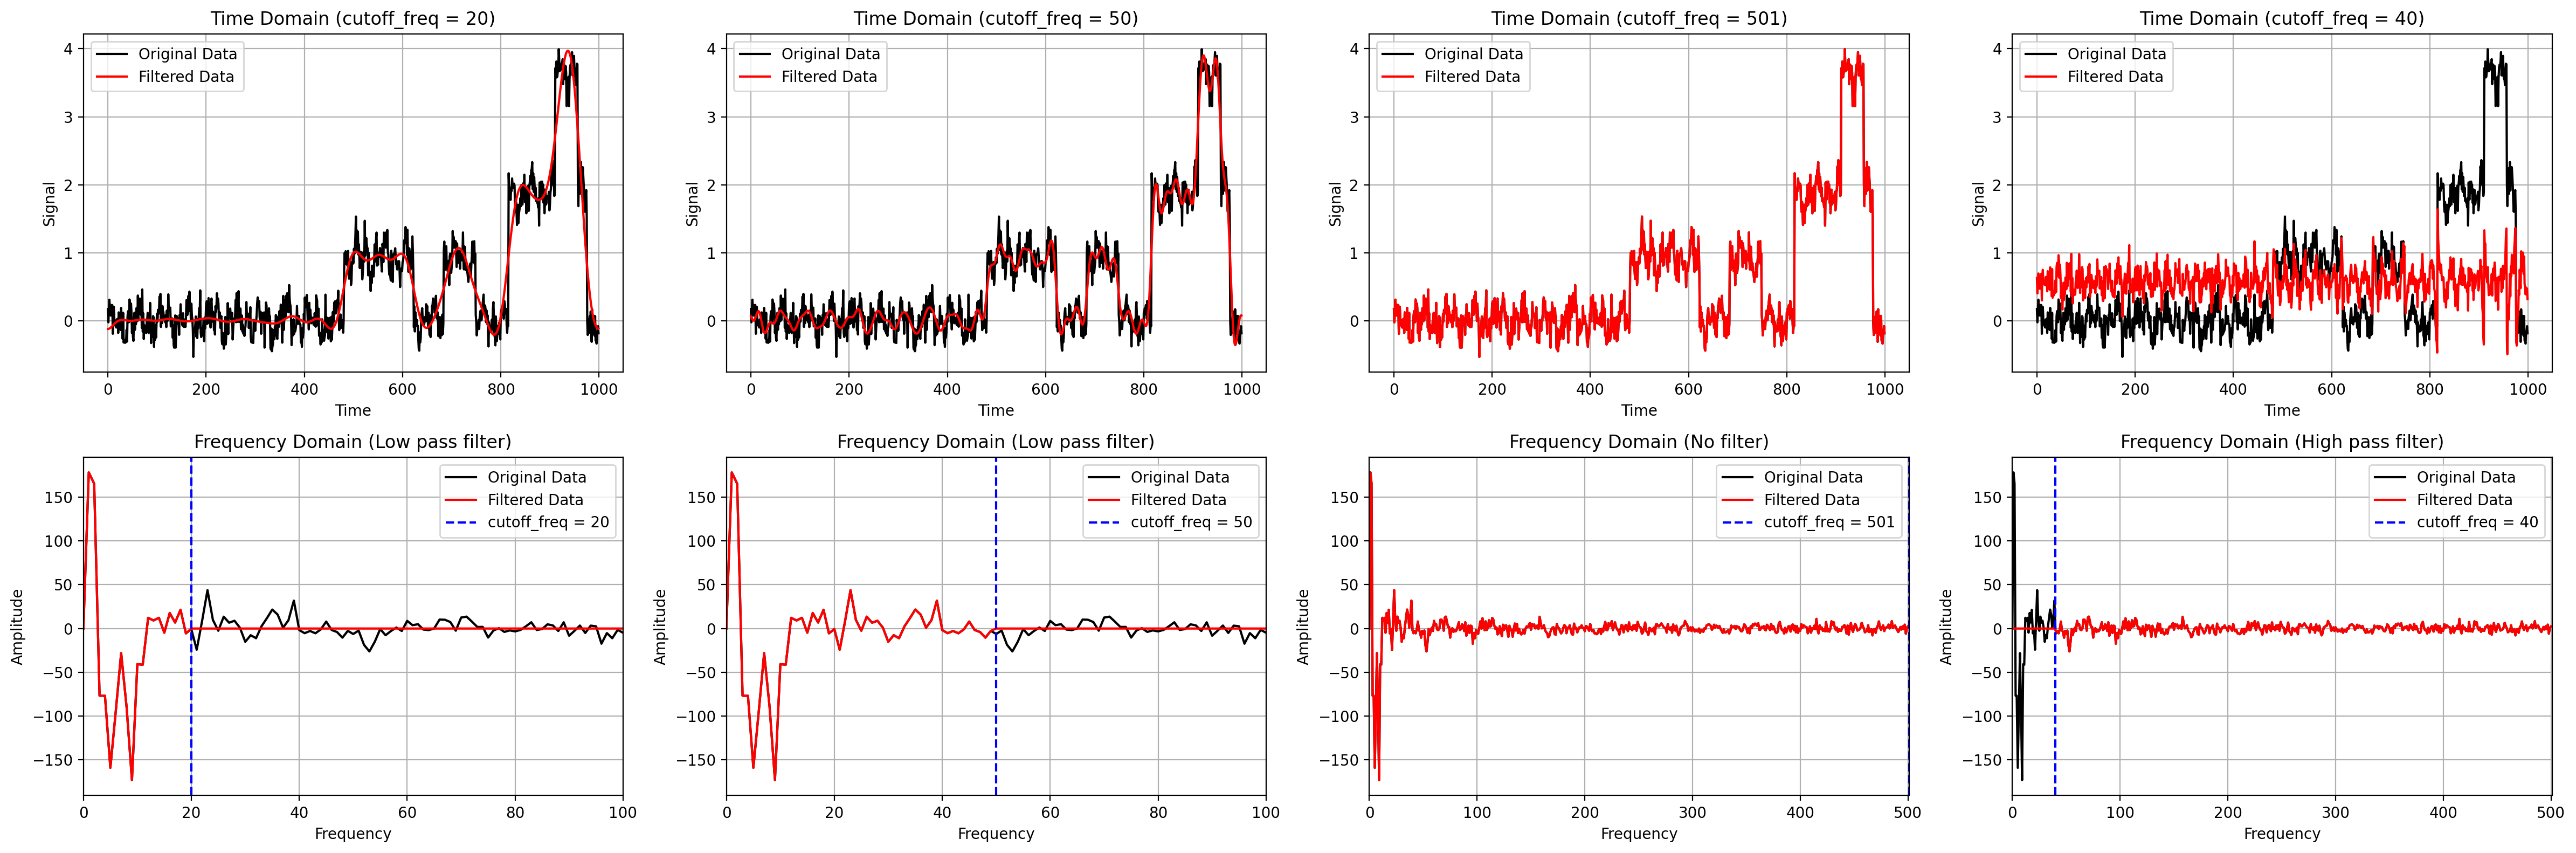

In [178]:
data_subset = y[:1000]

fig, axs = plt.subplots(2, 4, figsize=(24, 8))

# Define cutoff frequencies for low pass filters
cutoff_frequencies_lowpass = [20, 50, len(step12(data_subset))]

# Define cutoff frequency for high pass filter
cutoff_frequency_highpass = 40

# Plot for the first script (low pass filters)
for i, cutoff_freq in enumerate(cutoff_frequencies_lowpass):
    filtered_data = apply_low_pass_filter(data_subset, cutoff_freq)

    row = 0
    col = i

    axs[row, col].plot(data_subset, color='black', label='Original Data')
    axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
    axs[row, col].set_xlabel('Time')
    axs[row, col].set_ylabel('Signal')
    axs[row, col].set_title(f'Time Domain (cutoff_freq = {cutoff_freq})')
    axs[row, col].legend()
    axs[row, col].grid(True)

# Plot for the first script (high pass filter)
filtered_data = apply_high_pass_filter(data_subset, cutoff_frequency_highpass)

row = 0
col = 3

axs[row, col].plot(data_subset, color='black', label='Original Data')
axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
axs[row, col].set_xlabel('Time')
axs[row, col].set_ylabel('Signal')
axs[row, col].set_title(f'Time Domain (cutoff_freq = {cutoff_frequency_highpass})')
axs[row, col].legend()
axs[row, col].grid(True)

# Plot for the second script (low pass filters)
for i, cutoff_freq in enumerate(cutoff_frequencies_lowpass):
    original_data = step12(data_subset)
    filtered_data = step123(data_subset, cutoff_freq)

    row = 1
    col = i

    axs[row, col].plot(original_data, color='black', label='Original Data')
    axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
    axs[row, col].axvline(x=cutoff_freq, color='blue', linestyle='--', label=f'cutoff_freq = {cutoff_freq}')
    axs[row, col].set_xlabel('Frequency')
    axs[row, col].set_ylabel('Amplitude')
    axs[row, col].set_title(f'Frequency Domain (Low pass filter)')
    axs[row, col].legend()
    axs[row, col].grid(True)
    axs[row, col].set_xlim(0, 100)
    if cutoff_freq == cutoff_frequencies_lowpass[-1]:
        axs[row, col].set_title(f'Frequency Domain (No filter)')
        axs[row, col].set_xlim(0, len(step12(data_subset)))

# Plot for the second script (high pass filter)
original_data = step12(data_subset)
filtered_data = step123h(data_subset, cutoff_frequency_highpass)

row = 1
col = 3

axs[row, col].plot(original_data, color='black', label='Original Data')
axs[row, col].plot(filtered_data, color='red', label='Filtered Data')
axs[row, col].axvline(x=cutoff_frequency_highpass, color='blue', linestyle='--', label=f'cutoff_freq = {cutoff_frequency_highpass}')
axs[row, col].set_xlabel('Frequency')
axs[row, col].set_ylabel('Amplitude')
axs[row, col].set_title(f'Frequency Domain (High pass filter)')
axs[row, col].legend()
axs[row, col].grid(True)
axs[row, col].set_xlim(0, len(step12(data_subset)))

plt.tight_layout()
plt.show()